In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numpy.linalg as LA

In [2]:
epochs = 1000
gstop = 1e-7
max_iter = 50
def find_minima(x_0, A, sum_A, b, sum_b, B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g):
    global x_star
    x_star = np.zeros(d)
    global conv_iters
    conv_iters = 1
    print("Started IQN!")
    x = np.copy(x_0)
    
    for t in range(epochs):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            curr_grad_i = (A[i] @ x + b[i]) # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation

            # Update B (take a BFGS step in the descent direction)
            Bs = B_i @ s
            B[:, :, i] = B_i + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)

            # Update Binv in O(d ^ 2) time
            Binv_y = sum_B_inv @ y
            Z = sum_B_inv - np.outer(Binv_y, Binv_y.T) / (np.dot(s, y) + np.dot(y, Binv_y))
            ZBs = Z @ Bs
            sum_B_inv = Z + np.outer(ZBs, ZBs.T) / (np.dot(s, Bs) - np.dot(Bs, ZBs))
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B[:, :, i] @ x) - all_Bz[i]

            # Maintain the old variables
            all_Bz[i] = B[:, :, i] @ x
            all_z[i] = x
            all_g[i] = curr_grad_i
    
        gnorm = LA.norm(sum_A @ x + sum_b) / n
        if gnorm < gstop:
            print("Found minima after t : {} epochs".format(t))
            x_star = x
            conv_iters = t
            break
        print("(IQN) Current epoch : {} Current gnorm : {}".format(t, gnorm))
        
def IQN(x_0, A, sum_A, b, sum_b, B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g):
    y_axis_iqn = np.zeros(max_iter)
    print("Started IQN!")
    x = np.copy(x_0)
    for t in range(max_iter):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            curr_grad_i = (A[i] @ x + b[i]) # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation

            # Update B (take a BFGS step in the descent direction)
            Bs = B_i @ s
            B[:, :, i] = B_i + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)

            # Update Binv in O(d ^ 2) time
            Binv_y = sum_B_inv @ y
            Z = sum_B_inv - np.outer(Binv_y, Binv_y.T) / (np.dot(s, y) + np.dot(y, Binv_y))
            ZBs = Z @ Bs
            sum_B_inv = Z + np.outer(ZBs, ZBs.T) / (np.dot(s, Bs) - np.dot(Bs, ZBs))
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B[:, :, i] @ x) - all_Bz[i]

            # Maintain the old variables
            all_Bz[i] = B[:, :, i] @ x
            all_z[i] = x
            all_g[i] = curr_grad_i
        
        gnorm = LA.norm(sum_A @ x + sum_b) / n 
        y_axis_iqn[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        print("(IQN) Current epoch : {} Current gradient norm : {}".format(t, gnorm))
        
    return y_axis_iqn[max_iter - 1]

def Greedy_IQN(x_0, A, sum_A, b, sum_b, B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g, args):
    sum_B = LA.inv(sum_B_inv)
    print("Started Greedy IQN!")
    y_axis_giqn = np.zeros(max_iter)
    x = np.copy(x_0)
    M = 0 # tune this to change the convergence rate
    for t in range(max_iter):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            r = np.sqrt(np.dot(s, A[i] @ s)) # compute r = sqrt(s^T * Actual Hessian * s)
            
            curr_grad_i = A[i] @ x + b[i] # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation
            
            B_upon_A = np.diagonal(B_i) / np.diagonal(A[i])
            max_idx = np.argmax(B_upon_A)
            greedy_vec = np.zeros(d)
            greedy_vec[max_idx] = 1
            actual_hess_col = A[i][max_idx]
            
            Q = (1 + M * r) * B_i
            Qu = Q[max_idx] # Q @ u
            B_i = Q - np.outer(Qu, Qu.T) / Qu[max_idx] + np.outer(actual_hess_col, actual_hess_col.T) / actual_hess_col[max_idx]

            
            if args == 0:
                # M = 0, so this update can be done in O(d ^ 2) time
                psi2_inv_Qu = sum_B_inv @ Qu
                psi1_inv = sum_B_inv + np.outer(psi2_inv_Qu, psi2_inv_Qu.T) / (
                            Qu[max_idx] - np.dot(Qu, psi2_inv_Qu))

                psi1_inv_hessu = psi1_inv @ actual_hess_col
                sum_B_inv = psi1_inv - np.outer(psi1_inv_hessu, psi1_inv_hessu.T) / (
                            actual_hess_col[max_idx] + np.dot(actual_hess_col, psi1_inv_hessu))
                
            else:
                sum_B = sum_B + B_i - B[:, :, i]
                sum_B_inv = LA.inv(sum_B)
            
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B_i @ x) - all_Bz[i]

            # Maintain the old variables
            B[:, :, i] = B_i
            all_Bz[i] = B_i @ x
            all_z[i] = np.copy(x)
            all_g[i] = curr_grad_i
            
        y_axis_giqn[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        gnorm = LA.norm(sum_A @ x + sum_b) / n  
        print("(Greedy IQN) Current epoch : {} Current gradient norm : {}".format(t, gnorm))
        
    return y_axis_giqn[max_iter - 1]


def Hybrid_IQN(x_0, A, sum_A, b, sum_b, B, sum_B_inv, all_z, all_Bz, all_g, sum_Bz, sum_g, args):
    sum_B = LA.inv(sum_B_inv)
    print("Started Hybrid IQN!")
    x = np.copy(x_0)
    y_axis_hiqn = np.zeros(max_iter) 
    M = 0 # tune this to change the convergence rate
    for t in range(max_iter):
        for i in range(n):
            z_i = all_z[i]
            B_i = B[:, :, i]

            x = sum_B_inv @ (sum_Bz - sum_g)

            s = x - z_i # s denotes the variable variation
            r = np.sqrt(np.dot(s, A[i] @ s)) # compute r = sqrt(s^T * Actual Hessian * s)
            
            curr_grad_i = A[i] @ x + b[i] # denotes gradient of f_i at current x
            y = curr_grad_i - all_g[i] # y denotes the gradient variation
            
            # Update B (take a BFGS step in the descent direction)
            Bs = B_i @ s
            B_intermediate = B_i + np.outer(y, y.T) / np.dot(y, s) - np.outer(Bs, Bs.T) / np.dot(s, Bs)
            
            
            B_upon_A = np.diagonal(B_intermediate) / np.diagonal(A[i])
            max_idx = np.argmax(B_upon_A)
            greedy_vec = np.zeros(d)
            greedy_vec[max_idx] = 1
            actual_hess_col = A[i][max_idx]
            
            Q = ((1 + 0.5 * M * r) ** 2) * B_intermediate
            Qu = Q[max_idx] # Q @ u
            B_final = Q - np.outer(Qu, Qu.T) / Qu[max_idx] + np.outer(actual_hess_col, actual_hess_col.T) / actual_hess_col[max_idx]

            
            if args == 0:
                # The following updates are meant to update sum_B_inv in O(d ^ 2) time
                # Since M = 0, sum_B_inv = inv(sum D_i(t - 1)) (in the draft)
                sum_B_inv_y = sum_B_inv @ y
                psi3_inv = sum_B_inv - np.outer(sum_B_inv_y, sum_B_inv_y.T) / (
                    np.dot(y, s) + np.dot(y, sum_B_inv_y))

                psi3_inv_Bs = psi3_inv @ Bs
                psi2_inv = psi3_inv + np.outer(psi3_inv_Bs, psi3_inv_Bs.T) / (
                            np.dot(s, Bs) - np.dot(Bs, psi3_inv_Bs))

                psi2_inv_Qu = psi2_inv @ Qu
                psi1_inv = psi2_inv + np.outer(psi2_inv_Qu, psi2_inv_Qu.T) / (
                            Qu[max_idx] - np.dot(Qu, psi2_inv_Qu))

                psi1_inv_hessu = psi1_inv @ actual_hess_col
                sum_B_inv = psi1_inv - np.outer(psi1_inv_hessu, psi1_inv_hessu.T) / (
                            actual_hess_col[max_idx] + np.dot(actual_hess_col, psi1_inv_hessu))
            
            else:
                # Possible to do it in O(d ^ 2) through lazy propagration (but skipped)
                sum_B = sum_B + B_final - B[:, :, i]
                sum_B_inv = LA.inv(sum_B)
            
            sum_g = sum_g + y
            sum_Bz = sum_Bz + (B_final @ x) - all_Bz[i]

            # Maintain the old variables
            B[:, :, i] = B_final
            all_Bz[i] = B_final @ x
            all_z[i] = np.copy(x)
            all_g[i] = curr_grad_i
        
        y_axis_hiqn[t] = LA.norm(x - x_star) / LA.norm(x_0 - x_star)
        gnorm = LA.norm(sum_A @ x + sum_b) / n  
        print("(Hybrid IQN) Current epoch : {} Current gradient norm : {}".format(t, gnorm))

    return y_axis_hiqn[max_iter - 1]

In [4]:
# Generate data 
n = 100 # number of functions
xi = [1, 2.5, 4, 5] # Vary the condition number parameter
d = 100 # Dimension fixed
plot_iqn, plot_giqn, plot_hiqn = np.zeros(len(xi)), np.zeros(len(xi)), np.zeros(len(xi))
cond = []

for iter in range(len(xi)):
    A = []
    [L, mu] = [1e-10, 1e10]
    b = np.zeros((n, d))
    for i in range(n):
        a = np.zeros(d)
        # Sample the first d / 2 elements from [1, 10 ** (xi/2)]
        a[0: int(d / 2)] = np.random.uniform(1, 10 ** (0.5 * xi[iter]), size = int(d / 2))
        

        # Sample the next d / 2 elements from [10 ** (-xi/2), 1]
        a[int(d / 2): d] = np.random.uniform(10 ** (-0.5 * xi[iter]), 1, size = int(d / 2))
       
        L = max(L, np.max(a))
        mu = min(mu, np.min(a))
        A.append(np.diag(a))

        # b_i is generated by sampling from the box [0, 1000] ^ {d}
        b[i] = np.random.uniform(0, 1000, d)

    cond_no = L / mu
    cond.append(cond_no)
    sum_A = sum(A)
    sum_b = np.sum(b, axis = 0)

    x_0 = 0.1 * np.random.rand(d)
    B_approx = np.zeros((d, d, n))
    for i in range(n):
    #     B_approx[:, :, i] = 10 ** (0.75 * xi) * np.identity(d)
          B_approx[:, :, i] = L * np.identity(d)
    sum_B_inverse = LA.inv(np.sum(B_approx, 2))

    all_z_vals = np.zeros((n, d))
    for i in range(n):
        all_z_vals[i] = np.copy(x_0)


    all_gradients = np.zeros((n, d))
    for i in range(n):
        all_gradients[i] = (A[i] @ x_0) + b[i]
    sum_gradients = np.sum(all_gradients, axis = 0)

    all_Bz_vals = np.zeros((n, d))
    for i in range(n):
        all_Bz_vals[i] = B_approx[:, :, i] @ x_0
    sum_Bz_vals = np.sum(all_Bz_vals, axis = 0)

    initial_gradient_norm = LA.norm(sum_A @ x_0 + sum_b) / n
    print("Initial gradient norm : {}".format(initial_gradient_norm))

    find_minima(np.copy(x_0), np.copy(A), np.copy(sum_A), np.copy(b), np.copy(sum_b), np.copy(B_approx), np.copy(sum_B_inverse), 
        np.copy(all_z_vals), np.copy(all_Bz_vals), 
        np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients))

    plot_iqn[iter] = IQN(np.copy(x_0), np.copy(A), np.copy(sum_A), np.copy(b), np.copy(sum_b), np.copy(B_approx), np.copy(sum_B_inverse), 
        np.copy(all_z_vals), np.copy(all_Bz_vals), 
        np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients))


    plot_giqn[iter] = Greedy_IQN(np.copy(x_0), np.copy(A), np.copy(sum_A), np.copy(b), np.copy(sum_b), np.copy(B_approx), np.copy(sum_B_inverse), 
        np.copy(all_z_vals), np.copy(all_Bz_vals), 
        np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients), 1)

    plot_hiqn[iter] = Hybrid_IQN(np.copy(x_0), np.copy(A), np.copy(sum_A), np.copy(b), np.copy(sum_b), np.copy(B_approx), np.copy(sum_B_inverse), 
        np.copy(all_z_vals), np.copy(all_Bz_vals), 
        np.copy(all_gradients), np.copy(sum_Bz_vals), np.copy(sum_gradients), 0)

Initial gradient norm : 5022.124249014408
Started IQN!
(IQN) Current epoch : 0 Current gnorm : 1394.9515913106768
(IQN) Current epoch : 1 Current gnorm : 529.9277391095013
(IQN) Current epoch : 2 Current gnorm : 35.54008352029771
(IQN) Current epoch : 3 Current gnorm : 18.623554939283068
(IQN) Current epoch : 4 Current gnorm : 4.164138504065402
(IQN) Current epoch : 5 Current gnorm : 0.6162118245922014
(IQN) Current epoch : 6 Current gnorm : 0.27751752063774726
(IQN) Current epoch : 7 Current gnorm : 0.09605355873258349
(IQN) Current epoch : 8 Current gnorm : 0.012492302226893974
(IQN) Current epoch : 9 Current gnorm : 0.004247537700240956
(IQN) Current epoch : 10 Current gnorm : 0.001912842758449411
(IQN) Current epoch : 11 Current gnorm : 0.00023613711286737807
(IQN) Current epoch : 12 Current gnorm : 5.591577732108471e-05
(IQN) Current epoch : 13 Current gnorm : 2.8754109905817526e-05
(IQN) Current epoch : 14 Current gnorm : 4.913463597003301e-06
(IQN) Current epoch : 15 Current gno

(Greedy IQN) Current epoch : 46 Current gradient norm : 3.4547852697035085e-11
(Greedy IQN) Current epoch : 47 Current gradient norm : 3.448727157661166e-11
(Greedy IQN) Current epoch : 48 Current gradient norm : 3.440666419516037e-11
(Greedy IQN) Current epoch : 49 Current gradient norm : 3.433758673200529e-11
Started Hybrid IQN!
(Hybrid IQN) Current epoch : 0 Current gradient norm : 1387.498480250659
(Hybrid IQN) Current epoch : 1 Current gradient norm : 520.8184612555946
(Hybrid IQN) Current epoch : 2 Current gradient norm : 32.869802276977175
(Hybrid IQN) Current epoch : 3 Current gradient norm : 15.792370608770725
(Hybrid IQN) Current epoch : 4 Current gradient norm : 3.514525997688758
(Hybrid IQN) Current epoch : 5 Current gradient norm : 0.4160922318298648
(Hybrid IQN) Current epoch : 6 Current gradient norm : 0.14191910697990795
(Hybrid IQN) Current epoch : 7 Current gradient norm : 0.052882885032466576
(Hybrid IQN) Current epoch : 8 Current gradient norm : 0.006848969095596419

(IQN) Current epoch : 29 Current gradient norm : 3.1833867279533304e-05
(IQN) Current epoch : 30 Current gradient norm : 7.130105205476704e-06
(IQN) Current epoch : 31 Current gradient norm : 1.4986653433828596e-06
(IQN) Current epoch : 32 Current gradient norm : 1.010976284943517e-06
(IQN) Current epoch : 33 Current gradient norm : 1.3194402147689884e-06
(IQN) Current epoch : 34 Current gradient norm : 1.0788443695227109e-06
(IQN) Current epoch : 35 Current gradient norm : 1.9275314537853754e-07
(IQN) Current epoch : 36 Current gradient norm : 5.173290543850525e-08
(IQN) Current epoch : 37 Current gradient norm : 4.147419577124573e-08
(IQN) Current epoch : 38 Current gradient norm : 5.6510094987826596e-08
(IQN) Current epoch : 39 Current gradient norm : 3.2592087503868576e-08
(IQN) Current epoch : 40 Current gradient norm : 4.353949933684774e-09
(IQN) Current epoch : 41 Current gradient norm : 1.5704020518780922e-09
(IQN) Current epoch : 42 Current gradient norm : 1.4773241354686976e-

(Hybrid IQN) Current epoch : 39 Current gradient norm : 3.219729794984858e-10
(Hybrid IQN) Current epoch : 40 Current gradient norm : 2.2550852592712923e-10
(Hybrid IQN) Current epoch : 41 Current gradient norm : 2.0427632937431348e-10
(Hybrid IQN) Current epoch : 42 Current gradient norm : 1.9957713004351953e-10
(Hybrid IQN) Current epoch : 43 Current gradient norm : 1.9829763853156758e-10
(Hybrid IQN) Current epoch : 44 Current gradient norm : 1.9707940900991153e-10
(Hybrid IQN) Current epoch : 45 Current gradient norm : 1.9888139063442665e-10
(Hybrid IQN) Current epoch : 46 Current gradient norm : 1.9984560342306834e-10
(Hybrid IQN) Current epoch : 47 Current gradient norm : 1.9994617476397312e-10
(Hybrid IQN) Current epoch : 48 Current gradient norm : 1.9923353653781747e-10
(Hybrid IQN) Current epoch : 49 Current gradient norm : 2.0024566902877514e-10
Initial gradient norm : 4991.141157135585
Started IQN!
(IQN) Current epoch : 0 Current gnorm : 5094.677342620885
(IQN) Current epoch

(Greedy IQN) Current epoch : 10 Current gradient norm : 3127.2478357915015
(Greedy IQN) Current epoch : 11 Current gradient norm : 3086.5906900555105
(Greedy IQN) Current epoch : 12 Current gradient norm : 3045.4057324964083
(Greedy IQN) Current epoch : 13 Current gradient norm : 3003.655698649787
(Greedy IQN) Current epoch : 14 Current gradient norm : 2961.3428326570165
(Greedy IQN) Current epoch : 15 Current gradient norm : 2918.420436337152
(Greedy IQN) Current epoch : 16 Current gradient norm : 2874.9087347405516
(Greedy IQN) Current epoch : 17 Current gradient norm : 2830.7177481228196
(Greedy IQN) Current epoch : 18 Current gradient norm : 2785.802211135516
(Greedy IQN) Current epoch : 19 Current gradient norm : 2740.1650596908385
(Greedy IQN) Current epoch : 20 Current gradient norm : 2693.759987817347
(Greedy IQN) Current epoch : 21 Current gradient norm : 2646.549290260871
(Greedy IQN) Current epoch : 22 Current gradient norm : 2598.505455624375
(Greedy IQN) Current epoch : 23

(IQN) Current epoch : 29 Current gnorm : 0.2794574545446875
(IQN) Current epoch : 30 Current gnorm : 0.08491387685438707
(IQN) Current epoch : 31 Current gnorm : 0.01294469109883555
(IQN) Current epoch : 32 Current gnorm : 0.00325853574491312
(IQN) Current epoch : 33 Current gnorm : 0.0026754431445614045
(IQN) Current epoch : 34 Current gnorm : 0.005038062590748568
(IQN) Current epoch : 35 Current gnorm : 0.012323839567194482
(IQN) Current epoch : 36 Current gnorm : 0.01511041077060199
(IQN) Current epoch : 37 Current gnorm : 0.0038238074590752863
(IQN) Current epoch : 38 Current gnorm : 0.0005869156546129595
(IQN) Current epoch : 39 Current gnorm : 0.00015652663487520025
(IQN) Current epoch : 40 Current gnorm : 0.0001306085737509127
(IQN) Current epoch : 41 Current gnorm : 0.00025315546424784787
(IQN) Current epoch : 42 Current gnorm : 0.0006098089134859957
(IQN) Current epoch : 43 Current gnorm : 0.0007168071621827021
(IQN) Current epoch : 44 Current gnorm : 0.00016841156931688136
(I

(Greedy IQN) Current epoch : 41 Current gradient norm : 2654.113574520383
(Greedy IQN) Current epoch : 42 Current gradient norm : 2598.9239802019642
(Greedy IQN) Current epoch : 43 Current gradient norm : 2536.466030335451
(Greedy IQN) Current epoch : 44 Current gradient norm : 2462.6304695375475
(Greedy IQN) Current epoch : 45 Current gradient norm : 2377.0903116659824
(Greedy IQN) Current epoch : 46 Current gradient norm : 2266.9561842443713
(Greedy IQN) Current epoch : 47 Current gradient norm : 2102.138413110706
(Greedy IQN) Current epoch : 48 Current gradient norm : 1749.8791633690917
(Greedy IQN) Current epoch : 49 Current gradient norm : 244.58206732211715
Started Hybrid IQN!
(Hybrid IQN) Current epoch : 0 Current gradient norm : 5150.852537140943
(Hybrid IQN) Current epoch : 1 Current gradient norm : 9666.649921486323
(Hybrid IQN) Current epoch : 2 Current gradient norm : 21620.9005926268
(Hybrid IQN) Current epoch : 3 Current gradient norm : 16733.58388810587
(Hybrid IQN) Curr

[9.988908475963015, 309.7388315948219, 9948.35301077163, 99904.47541942941]


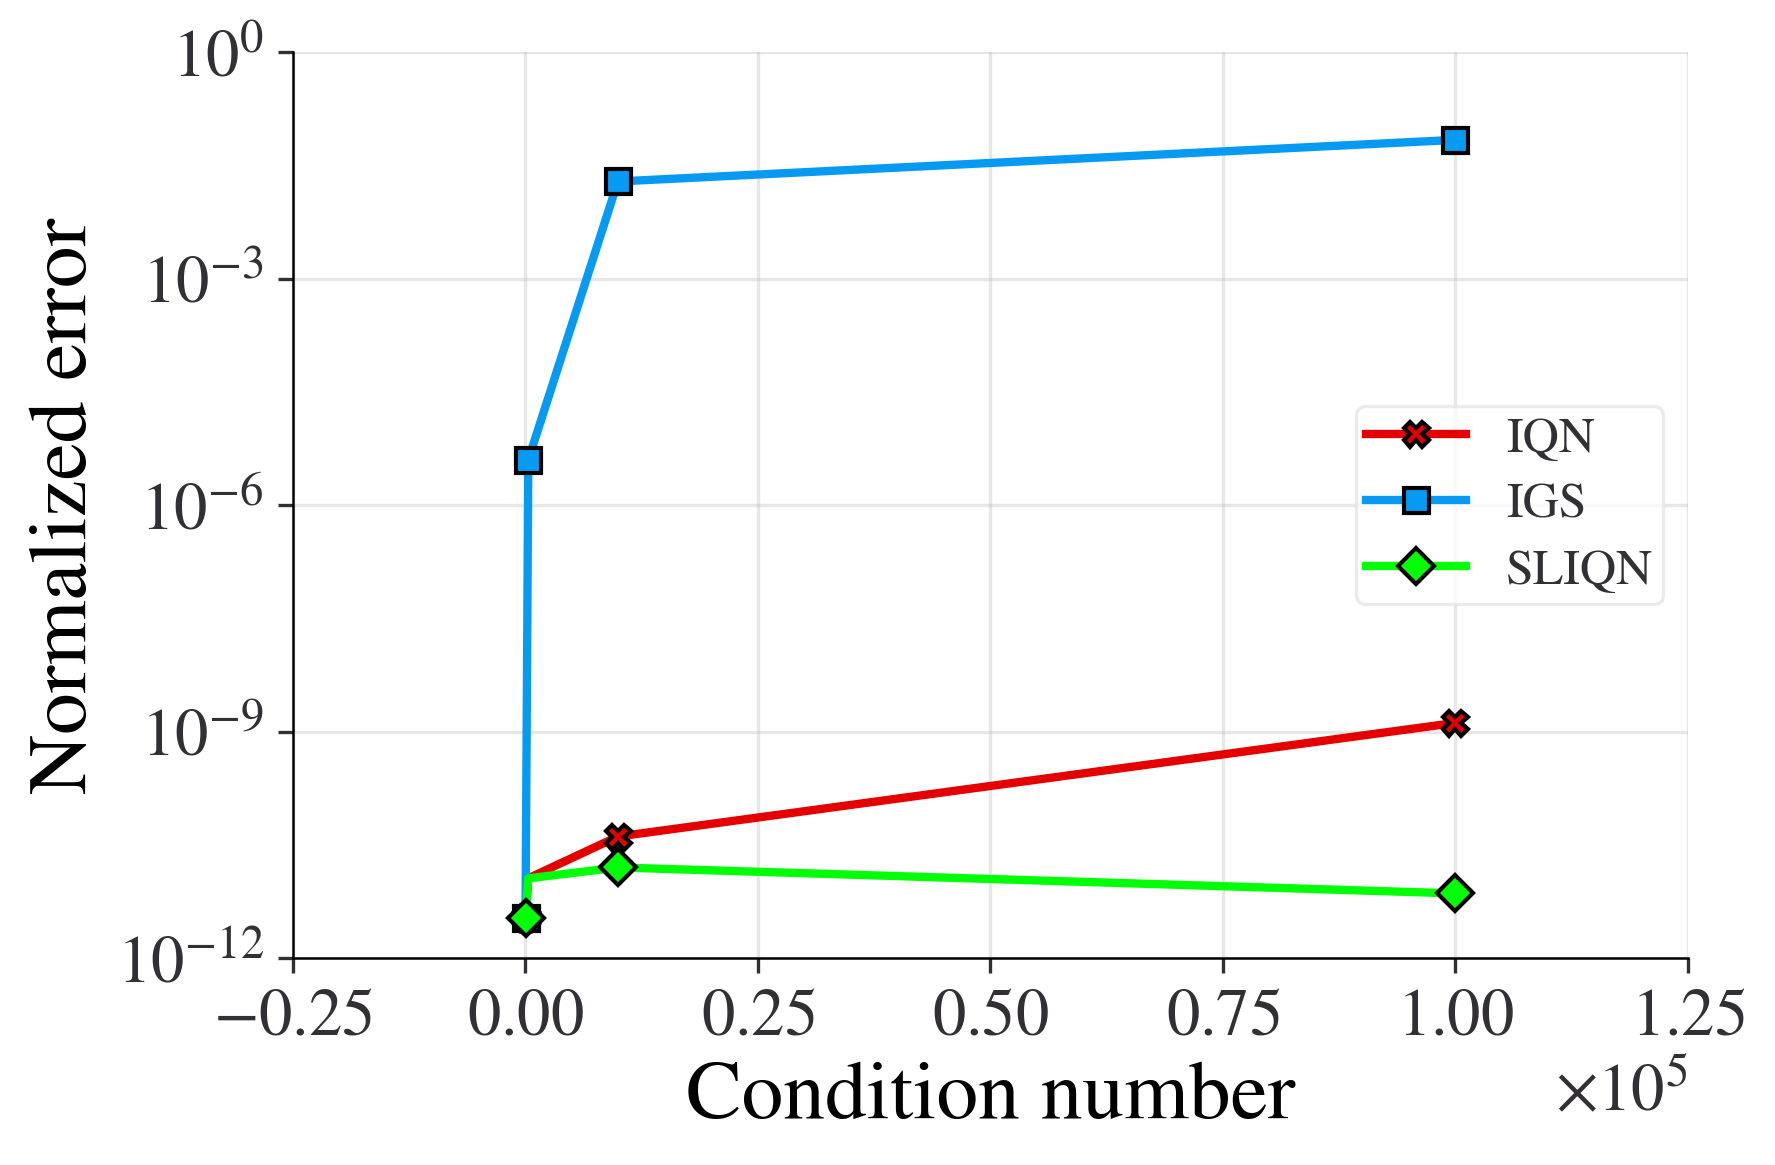

In [6]:
print(cond)
plt.style.use("plotstyle.txt")
plt.plot(cond, plot_iqn, 'X-', label = "IQN", color='xkcd:red', markevery = 0.1)
plt.plot(cond, plot_giqn, 's-', label = "IGS", color='xkcd:azure', markevery = 0.1)
plt.plot(cond, plot_hiqn, 'D-', label = "SLIQN", color='xkcd:bright green', markevery = 0.1)
plt.yscale('log')
# plt.xlim([0, 450])
plt.ylabel(r'Normalized error')
plt.xlabel(r'Condition number')
save_dir = "../Python_plots/condition_number" + "_N_" + str(n) + "_d_" + str(d) + "_xi_" + str(xi) + "_ep_" + str(max_iter) + ".png"
plt.legend()
plt.savefig(save_dir, bbox_inches = "tight")